**CNN MNIST**

Firstly, the necessary parckages are installed:

In [ ]:
import torch                                                            #Set up for PyTorch library
import os
import pathlib
import torchvision                                                      #For managing PyTorch datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F                                         #Necessary modules for model building, training and testing
import torch.nn as nn
import torch.optim as optim
import copy

from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.autograd import Variable

Agnostic code should be set up in order to maintain our variables and our computation in the same place:

In [ ]:
device='cuda'

In this case, we are using the dataset CIFAR10, provided by PyTorch. We proceed obtaining it and separating it into two sets: train and test. Afterwards, we organize the data into DataLoaders, which will allow us to divide our dataset in batches.

In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
#EuroSAT no define train/test, con lo que tomamos una proporcion /10
train_data = datasets.MNIST(root= "data",
                                   download=True,
                                   transform=transforms.ToTensor(),
                                   target_transform= None)
test_data = datasets.MNIST(root= "data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor(),
                                   target_transform= None)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79366f047970>,
 <torch.utils.data.dataloader.DataLoader at 0x79376997fcd0>)

Once the data is organized, we continue by constructing our model. It is helpful to create a neural network that is specialized to our dataset, thus after testing different structures the following has given better results accuracy-wise:

In [ ]:
class RF(nn.Module):                                                            #Define model class, torch.nn module
    def __init__(self,                                                          #Class constructor
                 input_shape: int,                                              #Input shape corresponds to color channels: 1 if BW, 3 if RGB
                 hidden_units: int,                                             #Number of neurons per layer: we have opted for equal number of neurons along CNN
                 output_shape: int):                                            #Output shape corresponds to number of labels
        super().__init__()                                                      #Initiallize parent class
        #Convolutional layers
        self.conv_block_1 = nn.Sequential(                                      #For each convolutional layer there are 2 convolutions,
            nn.Conv2d(in_channels=input_shape,                                  #each with Batch Normalization and a ReLU activation
                      out_channels=hidden_units,                                #function after.
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,                                            #Kernel size: Pixel area portion
                      stride=1,                                                 #Stride: Measure of pixel distance between kernels when convoluting
                      padding=0),                                               #Padding: Blank pixels added outside of image to control size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,                                         #After each convolutional layer we conduct MaxPooling
                     stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
        )
        #Fully-connected layer
        self.classifier = nn.Sequential(                                        #After convolution layers, we add a fully connected linear layer
            nn.Flatten(),                                                       #Eliminate dimensionality
            nn.Linear(in_features=hidden_units*5*5,                             #Depending on image size and number of concolutional layers and their parameters
                      out_features=output_shape)                                #it is necessary to adjust sizes manually
        )
    def forward(self, x):
      return self.classifier(self.conv_block_2(self.conv_block_1(x)))

As the convolutional model has been defined, we will now rely on PyTorch modules to define our train and test functions:

In [ ]:
#Train step for iteration during train phase
def train_step(model: torch.nn.Module,                               #Call model
               dataloader: torch.utils.data.DataLoader,              #Call DataLoader
               loss_fn: torch.nn.Module,                             #Call loss function
               optimizer:torch.optim.Optimizer,                      #Call optimizer function
               device=device):                                       #Select device
  #We set out model into training mode
  model.train()
  train_loss, train_acc = 0, 0                                       #The train loss and accuracy counts are initiallized
  # Loop over batches of DataLoader
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)                                #Send our data to designated device
    y_pred = model(X)                                                #Our model predict an outcome based on the input, outputs are logits.
    loss = loss_fn(y_pred, y)                                        #With the previous outdome we compute the losses with loss fucntion
    train_loss += loss.item()                                        #We add to the train loss count
    optimizer.zero_grad()                                            #A reset of the gradients is carried out to avoid accumulation from step to step
    loss.backward()                                                  #Computes gradient of tensor
    optimizer.step()                                                 #Updates parameters to optimize model
    # Calcualtion of accuracy parting from obtained logits
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)          #Addition to train accuracy list
  #Batch average
  best_accuracy = 0
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  if train_acc> best_accuracy:                                       #Step to save model if accuracy has been incresed with respect to last step
      print('Saving model...')
      torch.save(model.state_dict(), 'modelo_entrenado.pt')
      best_accuracy = train_acc
  return train_loss, train_acc


#Test step for iteration during inference
def test_step(model:torch.nn.Module,                                 #Call model
              dataloader: torch.utils.data.DataLoader,               #Call DataLoader
              loss_fn: torch.nn.Module,                              #Call loss function, no optimization is done during inference
              device):                                               #Select device

  #Set model into evaulation mode
  model.eval()
  test_loss, test_acc = 0,  0                                        #The train loss and accuracy counts are initiallized
  with torch.inference_mode():                                       #Using the module's inference mode we test the model
    # Loop over batches of DataLoader
    for batch, (X, y) in enumerate(dataloader):
      a,b = X.to(device), y.to(device)                               #Send our data to designated device
      test_pred_logits = model(a)
      loss = loss_fn(test_pred_logits, b)                            #Loss calculation using predicted logits
      test_loss += loss.item()
      test_pred_labels = test_pred_logits.argmax(dim=1)                           #Obtaning labels from predictions
      test_acc += ((test_pred_labels == b).sum().item()/len(test_pred_labels))    #Comparison of labels with data and addition to accuracy count
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In order to train our model and evaluate its accuracy on the test set, it is necessary to write a loop function that combines the previous two:

In [ ]:
#Training loop
from tqdm.auto import tqdm                                           #Displays visual loading bar

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,                                             #Amount of epochs of training
          device=device):

  results = {"train_loss": [],                                       #Count initiation
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):                                  #Loop over epochs
    train_loss, train_acc = train_step(model=model,                  #Call to train step
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,                     #Call to test step
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    #Display results
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)                         #Addition of new values to lists
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

We procceed with the training of our model:

In [ ]:
NUM_EPOCHS = 100                                                           #Write number of traing epochs
model_0 = RF(input_shape=1,                                                #Call to model and shape parameters
             hidden_units=10,
             output_shape=10).to(device)

# Loss function and optimization
loss_fn = nn.CrossEntropyLoss()                                            #Loss function
optimizer = torch.optim.Adam(params=model_0.parameters(),                  #Optimizer function
                             lr=0.001)

from timeit import default_timer as timer                                  #Timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,                                     #Entrenamiento
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

**Memtorch**

Memtorch installation taking into account that skelearn is a deprecated name, now its name is scikit-learn. Also it is necessary to allow cuda functionality to work on cuda.

In [ ]:
!git clone --recursive https://github.com/coreylammie/MemTorch              #Accessing repository
!sed -i 's/sklearn/scikit-learn/gi' MemTorch/requirements.txt               #sklearn changed name to scikit-learn
!sed -i 's/sklearn/scikit-learn/gi' MemTorch/setup.py                       #Switch in requirements.txt and setup.py
%cd MemTorch
!sed -i 's/CUDA = False/CUDA = True/g' setup.py                             #Installation with CUDA functionality
!pip install .
%cd ..

fatal: destination path 'MemTorch' already exists and is not an empty directory.
/content/MemTorch
Processing /content/MemTorch
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 417, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 320, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 194, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_

Memtorch is imported with the necesarry modules.

In [ ]:
import memtorch                                                             #Obtaining of Memtorch
from memtorch.mn.Module import patch_model                                  #Memtorch module to patch model
from memtorch.map.Input import naive_scale
from memtorch.map.Parameter import naive_map

A memristor model is selected, in our case it is VTEAM, a voltage-controlled memristor. A time resolution is described in order to sset the rate of updates. We plot the hysteresis loop as well as the switching behaviour of the chosen memristor.

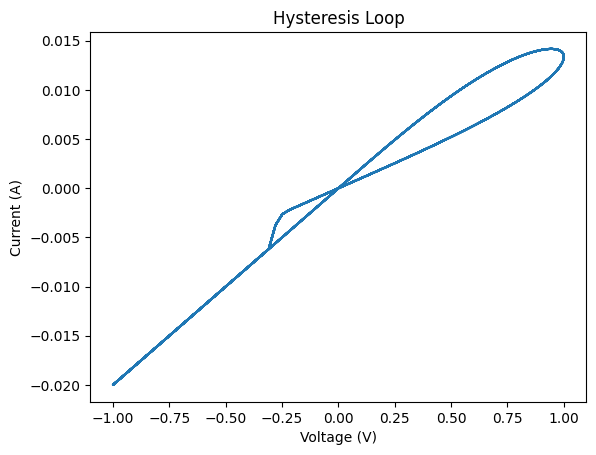

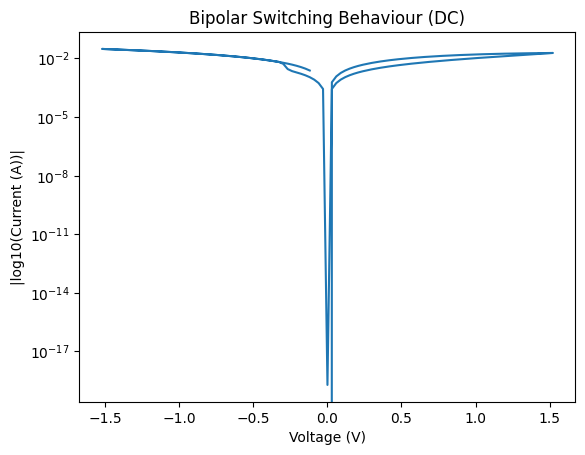

In [ ]:
reference_memristor = memtorch.bh.memristor.VTEAM                           #Selection of memristor
reference_memristor_params = {'time_series_resolution': 1e-10}              #Parameter selection: time resolution for simulation
memristor = reference_memristor(**reference_memristor_params)               #Define memristor with parameters
memristor.plot_hysteresis_loop()                                            #Plotting of hysteresis loop
memristor.plot_bipolar_switching_behaviour()                                #Plotting of switching behaviour

We patch out current trained model (loading its state dictionary) to a memristive crossbar array, mapping weights into conductances.

In [ ]:
import copy                                                                     #Needed to copy model in order to patch it
from memtorch.mn.Module import patch_model
from memtorch.map.Input import naive_scale
from memtorch.map.Parameter import naive_map

loss_fn = nn.CrossEntropyLoss()
model = RF(input_shape=1,                                                       #Model with shape
           hidden_units=10,
           output_shape=10).to(device)
model.load_state_dict(torch.load('MNIST_trained.pt'), strict=False)                              #Load state dictionary with trained values
patched_model = patch_model(copy.deepcopy(model),                                                #Copy model to patch
                          memristor_model=reference_memristor,                                   #Select defined memristor
                          memristor_model_params=reference_memristor_params,                     #Select defined parameters for memristor
                          module_parameters_to_patch=[torch.nn.Conv2d],         #Select type of layer to patch (only Conv2D in our CNNs)
                          mapping_routine=naive_map,
                          scheme=memtorch.bh.Scheme.DoubleColumn,
                          transistor=True,
                          programming_routine=None,
                          tile_shape=(128, 128),
                          max_input_voltage=0.3,
                          scaling_routine=naive_scale,
                          ADC_resolution=8,
                          ADC_overflow_rate=0.,
                          quant_method='linear')
patched_model.tune_()

Patched Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1)) -> bh.Conv2d(in_channels=1, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
Patched Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1)) -> bh.Conv2d(in_channels=10, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
Patched Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1)) -> bh.Conv2d(in_channels=10, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
Patched Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1)) -> bh.Conv2d(in_channels=10, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
Tuned bh.Conv2d(in_channels=1, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0)). Coefficient of determination: 0.882772 [296.457092, -0.027194]
Tuned bh.Conv2d(in_channels=10, out_channels=10, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0)). Coefficient of determination: 0.881275 [299.727448, -0.075722]
Tuned bh.Conv2d(in_channels=10, out_channels=10, kernel

We test our patched model model:

In [ ]:
test_step(model=patched_model,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1.8779025568008423, 0.444)

In [ ]:
test_step(model=model,
          dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

(0.10775812108645612, 0.9809)

**Non-idealities**



Device Faults:

In [ ]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

patched_model_1 = apply_nonidealities(copy.deepcopy(patched_model),
                                     non_idealities=[memtorch.bh.nonideality.NonIdeality.DeviceFaults],
                                     lrs_proportion=0.25,
                                     hrs_proportion=0.10,
                                     electroform_proportion=0)

In [ ]:
test_step(model=patched_model_1,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

(188.6673449584961, 0.0841)

Endurance:

In [ ]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

patched_model_2 = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.Endurance],
                                  x=1e4,
                                  endurance_model=memtorch.bh.nonideality.endurance_retention_models.model_endurance_retention,
                                  endurance_model_kwargs={
                                        "operation_mode": memtorch.bh.nonideality.endurance_retention_models.OperationMode.sudden,
                                        "p_lrs": [1, 0, 0, 0],
                                        "stable_resistance_lrs": 100,
                                        "p_hrs": [1, 0, 0, 0],
                                        "stable_resistance_hrs": 1000,
                                        "cell_size": 10,
                                        "temperature": 350,
                                  })

In [ ]:
test_step(model=patched_model_2,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

(10.357280444335938, 0.1689)

Retention:

In [ ]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

patched_model_3 = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.Retention],
                                  time=1e3,
                                  retention_model=memtorch.bh.nonideality.endurance_retention_models.model_conductance_drift,
                                  retention_model_kwargs={
                                        "initial_time": 1,
                                        "drift_coefficient": 0.1,
                                  })

In [ ]:
test_step(model=patched_model_3,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

(4.162054451370239, 0.111)

Finite condution states:

In [ ]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

patched_model_4 = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.FiniteConductanceStates],
                                  conductance_states=5)

In [ ]:
test_step(model=patched_model_4,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

(4.743512579345703, 0.113)

Nonlinear behaviour:

In [ ]:
from memtorch.bh.nonideality.NonIdeality import apply_nonidealities

patched_model_5 = apply_nonidealities(copy.deepcopy(patched_model),
                                  non_idealities=[memtorch.bh.nonideality.NonIdeality.NonLinear],
                                  simulate=True)

In [ ]:
test_step(model=patched_model_5,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

IndexError: index 4 is out of bounds for axis 0 with size 1

Stochastic parameters:

In [ ]:
import memtorch

reference_memristor = memtorch.bh.memristor.VTEAM
reference_memristor_params = {'time_series_resolution': 1e-10,
                              'r_off': memtorch.bh.StochasticParameter(loc=1000, scale=200, min=2),
                              'r_on': memtorch.bh.StochasticParameter(loc=5000, scale=sigma, min=1)}

memristor = reference_memristor(**reference_memristor_params)
memristor.plot_hysteresis_loop()
memristor.plot_bipolar_switching_behaviour()

Combination:

In [ ]:
patched_model_ = apply_nonidealities(copy.deepcopy(patched_model),
                                     non_idealities=[memtorch.bh.nonideality.NonIdeality.DeviceFaults,
                                                     memtorch.bh.nonideality.NonIdeality.Endurance,
                                                     memtorch.bh.nonideality.NonIdeality.Retention,
                                                     memtorch.bh.nonideality.NonIdeality.NonLinear,
                                                     memtorch.bh.nonideality.NonIdeality.FiniteConductanceStates],
                                     lrs_proportion=0.25,
                                     hrs_proportion=0.10,
                                     electroform_proportion=0,
                                     x=1e4,
                                     endurance_model=memtorch.bh.nonideality.endurance_retention_models.model_endurance_retention,
                                     endurance_model_kwargs={
                                        "operation_mode": memtorch.bh.nonideality.endurance_retention_models.OperationMode.sudden,
                                        "p_lrs": [1, 0, 0, 0],
                                        "stable_resistance_lrs": 100,
                                        "p_hrs": [1, 0, 0, 0],
                                        "stable_resistance_hrs": 1000,
                                        "cell_size": 10,
                                        "temperature": 350,
                                     },
                                     time=1e3,
                                     retention_model=memtorch.bh.nonideality.endurance_retention_models.model_conductance_drift,
                                     retention_model_kwargs={
                                         "initial_time": 1,
                                         "drift_coefficient": 0.1,
                                     },
                                     conductance_states=5,
                                     simulate=True
                                    )

In [ ]:
test_step(model=patched_model_,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device='cuda')

IndexError: index 4 is out of bounds for axis 0 with size 1